# Spanish unemployment rates_Assigment_Coursera

In this assignment we will estimate unemployment rates in Spain, using *pandas* for reading information, *scikit-learn* for training estimators, and *geopandas* and *folium* for visualizing results.

In [75]:
import pandas as pd
import numpy as np
import branca.colormap as cm
import utils
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR, SVR
from sklearn.metrics import r2_score
from math import ceil
%matplotlib inline

## 1. Load and understand data

To begin with, let us read some **numerical characteristics of Spanish municipalities**: 

In [76]:
muns_population = utils.read_population('./data/municipios.csv')
print(len(muns_population))
muns_population.head()

8112


lat       lon        alt  habitantes
com_aut   prov    mun                                                 
Andalucía Almería Abla       37.14114 -2.780104  871.16840        1504
                  Abrucena   37.13305 -2.797098  976.93870        1341
                  Adra       36.74807 -3.022522   10.97898       24373
                  Albánchez  37.28710 -2.181163  481.31230         815
                  Alboloduy  37.03319 -2.621750  388.43460         674

As you can see, **for each municipality we have its position (latitude and longitude in degrees), its altitude (in meters) and its population (number of inhabitants)**. The resulting dataframe is **indexed in a hierarchical way, first by autonomous community, then by province, and finally by municipality name, for a total of 8112 municipalities**.

Our goal is to **predict the yearly unemployment rate for each municipality in 2017**. Let us read the unemployment data belonging to that year:

In [77]:
unempl_2017 = utils.read_unemployment('./data/Paro_por_municipios_2017.csv')   # use specific load function from utils module
print(len(unempl_2017), len(unempl_2017.index.unique()))
unempl_2017.head()

97512 8126


año  mes  parados
com_aut   prov    mun                          
Andalucía Almería Abla       2017    1       77
                  Abrucena   2017    1       81
                  Adra       2017    1     2097
                  Albánchez  2017    1       20
                  Alboloduy  2017    1       44

These data are indexed in the same way as *muns_population* above. However, we are interested in yearly unemployment, but **we have monthly information** (actually, 97512 observations from 8126 municipalities). For example, taking the municipality of Abla:

In [78]:
unempl_2017.xs(key='Abla', level=utils.MUN_FIELD, drop_level=False)      # all records whose mun is Abla, keeping index intact

año  mes  parados
com_aut   prov    mun                     
Andalucía Almería Abla  2017    1       77
                  Abla  2017    2       79
                  Abla  2017    3       87
                  Abla  2017    4       90
                  Abla  2017    5       85
                  Abla  2017    6       83
                  Abla  2017    7       81
                  Abla  2017    8       88
                  Abla  2017    9       82
                  Abla  2017   10       88
                  Abla  2017   11       81
                  Abla  2017   12       83

Using grouping, it is fairly easy to obtain the **yearly means** for each municipality:

In [79]:
unempl_2017_means = unempl_2017.groupby(unempl_2017.index.names)[[utils.UNEMPL_FIELD]].mean()   # group by all index levels, then take the mean
assert(len(unempl_2017_means) == len(unempl_2017) // 12)       # there should be just 1 row for each municipality
unempl_2017_means.head()

parados
com_aut   prov    mun                   
Andalucía Almería Abla         83.666667
                  Abrucena     74.666667
                  Adra       2433.750000
                  Alboloduy    35.416667
                  Albox       808.916667

Now, in order to obtain our target values, we just need to transform these raw figures to unemployment rates, that is, we have to **divide unemployment by each municipality's population**:

In [80]:
unempl_2017_means.head()
unempl_2017_means.shape

(8126, 1)

In [81]:
muns_population.head()
muns_population.shape

(8112, 4)

In [82]:
df=pd.merge(unempl_2017_means, muns_population, on=['com_aut','prov','mun'], how="inner")
print(df.shape)
df.head()

(8111, 5)


parados       lat       lon        alt  \
com_aut   prov    mun                                                     
Andalucía Almería Abla         83.666667  37.14114 -2.780104  871.16840   
                  Abrucena     74.666667  37.13305 -2.797098  976.93870   
                  Adra       2433.750000  36.74807 -3.022522   10.97898   
                  Alboloduy    35.416667  37.03319 -2.621750  388.43460   
                  Albox       808.916667  37.38979 -2.147483  426.42680   

                             habitantes  
com_aut   prov    mun                    
Andalucía Almería Abla             1504  
                  Abrucena         1341  
                  Adra            24373  
                  Alboloduy         674  
                  Albox           11178

In [83]:
Y= df["parados"]/df["habitantes"]
type(Y)

pandas.core.series.Series

In [84]:
df_outer=pd.merge(unempl_2017_means, muns_population, on=['com_aut','prov','mun'], how="outer")
u_pop=df_outer[(df_outer["habitantes"].isnull()) & (df_outer["parados"].notnull())]

In [85]:
mund = u_pop.index.get_level_values('mun')
mund.tolist()

['Balanegra',
 'Dehesas Viejas',
 'Domingo Pérez de Granada',
 'Játar',
 'Valderrubio',
 'Montecorto',
 'Serrato',
 'Villanueva de la Concepción',
 'Canonja, La',
 'Guadiana del Caudillo',
 'Alagón del Río',
 'Tiétar',
 'Vegaviana',
 'Oza-Cesuras',
 'Noáin (Valle de Elorz)/Noain (Elortzibar)']

Great, so we already have Y, but we need patterns X to train a model. Which features should we use? Well, to begin with **we can use all features from muns\_population, since they are numerical**:

In [86]:
X=df[["lat","lon","alt","habitantes"]]

Utilizar la variable **habitantes** que representa el número de habitantes por cada uno de los municipios, no falsea los resultados ya que aun así desconocemos los desempleados.

You should have obtained X and Y in the same order:

In [87]:
assert(isinstance(X, pd.DataFrame)) 
assert(all(X.columns == muns_population.columns))
assert(all(X.index == Y.index))

## 2. Baseline models

Cool, we are ready to exploit Machine Learning. We just need to **split the data into training and set sets**. Let us fix the random seed and the ratio of data for training and test:

In [88]:
RANDOM_STATE = 42   # fix seed
TEST_PERC = 0.3     # 30% for test, 70% for training

In [89]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_PERC,random_state=RANDOM_STATE)

Let us verify that data have been split correctly:

In [17]:
assert(len(X_test) == ceil(TEST_PERC*len(X)) and len(Y_test) == len(X_test))       # test set size is 30% of total size
assert(len(X_train) == len(X)-len(X_test) and len(Y_train) == len(X_train))     # every pattern not in test should be in train

And create **colors to plot in a map the unemployment rate of each municipality**:

In [90]:
cmap = cm.LinearColormap(colors=['green', 'yellow', 'orange', 'red', 'black'], 
                                 vmin=round(Y.min(), 2), vmax=round(Y.max(), 2), 
                                 caption='Unemployment rate')
cmap

The following code generates the map corresponding to the true values of patterns in the test set, saving this map as an HTML document:

In [91]:
coms = utils.read_communities('./data/ComunidadesAutonomas_ETRS89_30N/')      # read communities
provs = utils.read_provinces('./data/Provincias_ETRS89_30N/')     # read provinces
_ = utils.generate_map(pd.concat([X_test, Y_test], axis=1),      # generate map, which needs X and Y together...
                       utils.LAT_FIELD, utils.LON_FIELD, Y_test.name if Y_test.name is not None else 0,   # columns with latitude, longitude and unemployment...
                       cmap, coms=coms, provs=provs, filename='./test_true.html')    # colors, communities, provinces and where to store the map

Empleamos **linear SVR** que acepta los hiperparámetros C y epsilon. Buscaremos el más optimo aplicando GridSearch CV. Para el Scoring utilizamos **neg_mean_squared_error**.:
+ **C**: Penalty parameter C of the error term.

+ **Epsilon**: Epsilon in the epsilon-SVR model. It specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value.

In [92]:
Cs = [0.00005,0.0001,0.0002,0.00025,0.001,0.01,0.1]
epsilons=  [0.001,0.01,0.02,0.025,0.027,0.03,0.04]

#Cs= print(np.logspace(-5,1, 20))
#NOTA: Tenía puesto el np.logspace pero he preferido ir ajustando de forma manual analizando la ventana.

In [93]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

pl = Pipeline(steps=[("estandarizador", StandardScaler()),
                     ("svr", SVR(kernel='linear'))])

hp= {"svr__C":Cs,
     "svr__epsilon":epsilons}

gs1 = GridSearchCV(estimator= pl,
                  param_grid=hp,
                  cv=10, #Numero de splits/iteraciones de cross validation
                  verbose=5, #Imprime el progreso
                  scoring='neg_mean_squared_error',
                  return_train_score=False,
                  n_jobs=-1)

gs1.fit(X_train, Y_train)

Fitting 10 folds for each of 49 candidates, totalling 490 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed:   28.7s finished
/anaconda3/envs/svm_labs/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/svm_labs/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('estandarizador', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'svr__C': [5e-05, 0.0001, 0.0002, 0.00025, 0.001, 0.01, 0.1], 'svr__epsilon': [0.001, 0.01, 0.02, 0.025, 0.027, 0.03, 0.04]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='neg_mean_squared_error', verbose=5)

In [99]:
best_model1= gs1.best_estimator_
best_C1= gs1.best_params_["svr__C"]
best_epsilon1= gs1.best_params_["svr__epsilon"]
mses1= np.reshape(gs1.cv_results_['mean_test_score'], (len(Cs),len(epsilons)))

In [100]:
gs1.best_params_

{'svr__C': 0.00025, 'svr__epsilon': 0.025}

In [101]:
gs1.best_score_

-0.0006090616383191423

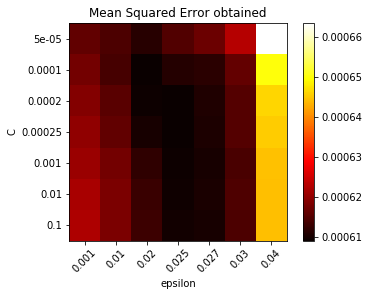

In [102]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(abs(mses1), interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('epsilon')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(epsilons)), epsilons, rotation=45)
plt.yticks(np.arange(len(Cs)), Cs)
plt.title('Mean Squared Error obtained')
plt.show()

#NOTA SI LOS MEJORES VALORES SALEN POR EL INTERIOR SE INDICA QUE LA BUSQUEDA HA SIDO BUENA, HEMOS PROBADO
#LOS PARAMETROS QUE QUERÍAMOS. 

Cuanto menor sea el valor de MSE mejor se está comportanto nuestro modelo, por lo que la matriz mostrada, colores oscuros (C, Epsilon) determinan un valor mas bajo de MSE y por tanto un menor error. 

Let us try to **interpret what the resulting SVM is doing**:

In [103]:
Y_pred1 = best_model1.predict(X_test)

/anaconda3/envs/svm_labs/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [104]:
#Lo transformo en un Pandas Series para poder hacer pd.concat y poder mostrarlo en el mapa. 
Y_pred1=pd.Series(Y_pred1, index=X_test.index)

In [105]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_test, Y_pred1)

0.0006101162735897806

No hay sobreajuste, el mean squared error es muy similar en train y test.

In [106]:
_ = utils.generate_map(pd.concat([X_test, Y_pred1], axis=1),      # generate map, which needs X and Y together...
                       utils.LAT_FIELD, utils.LON_FIELD, Y_pred1.name if Y_pred1.name is not None else 0,   # columns with latitude, longitude and unemployment...
                       cmap, coms=coms, provs=provs, filename='./test_predicted1.html')   # colors, communities, provinces and where to store the map

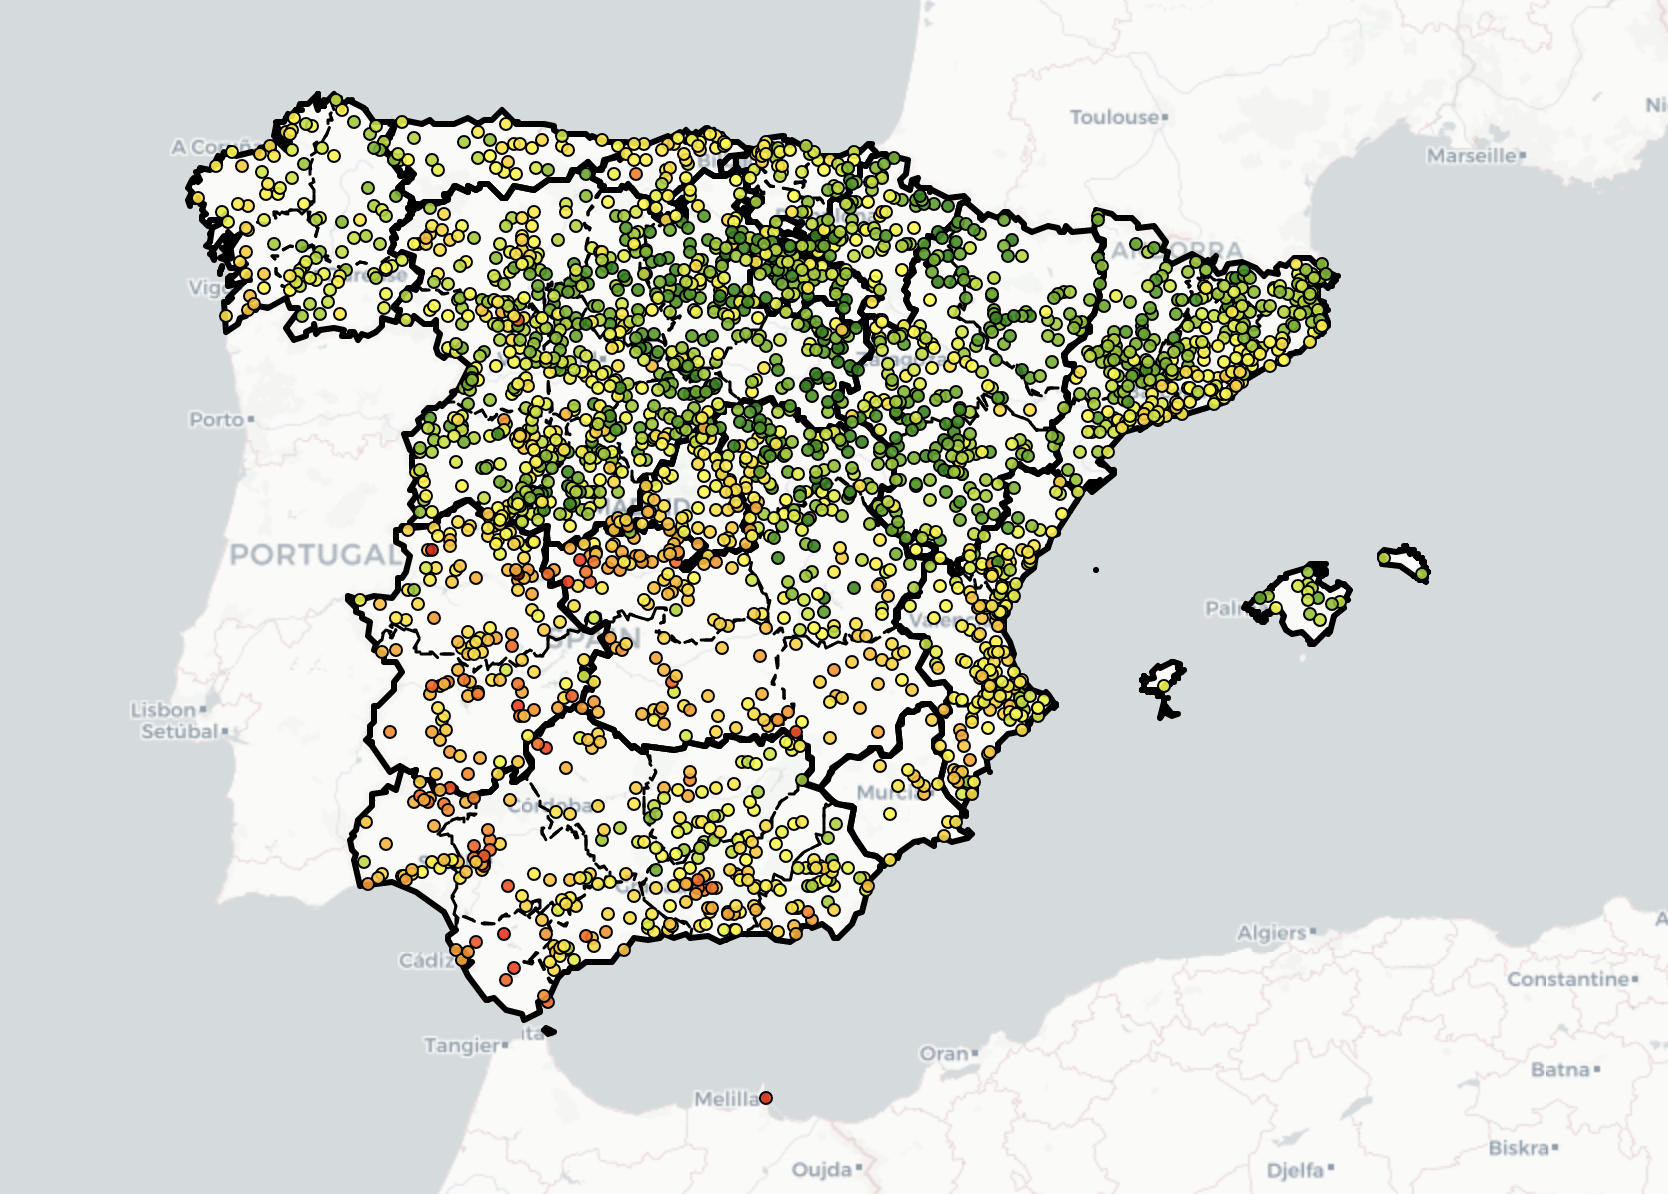

In [31]:
from IPython.display import Image
Image(filename='test_real_lineal.png')

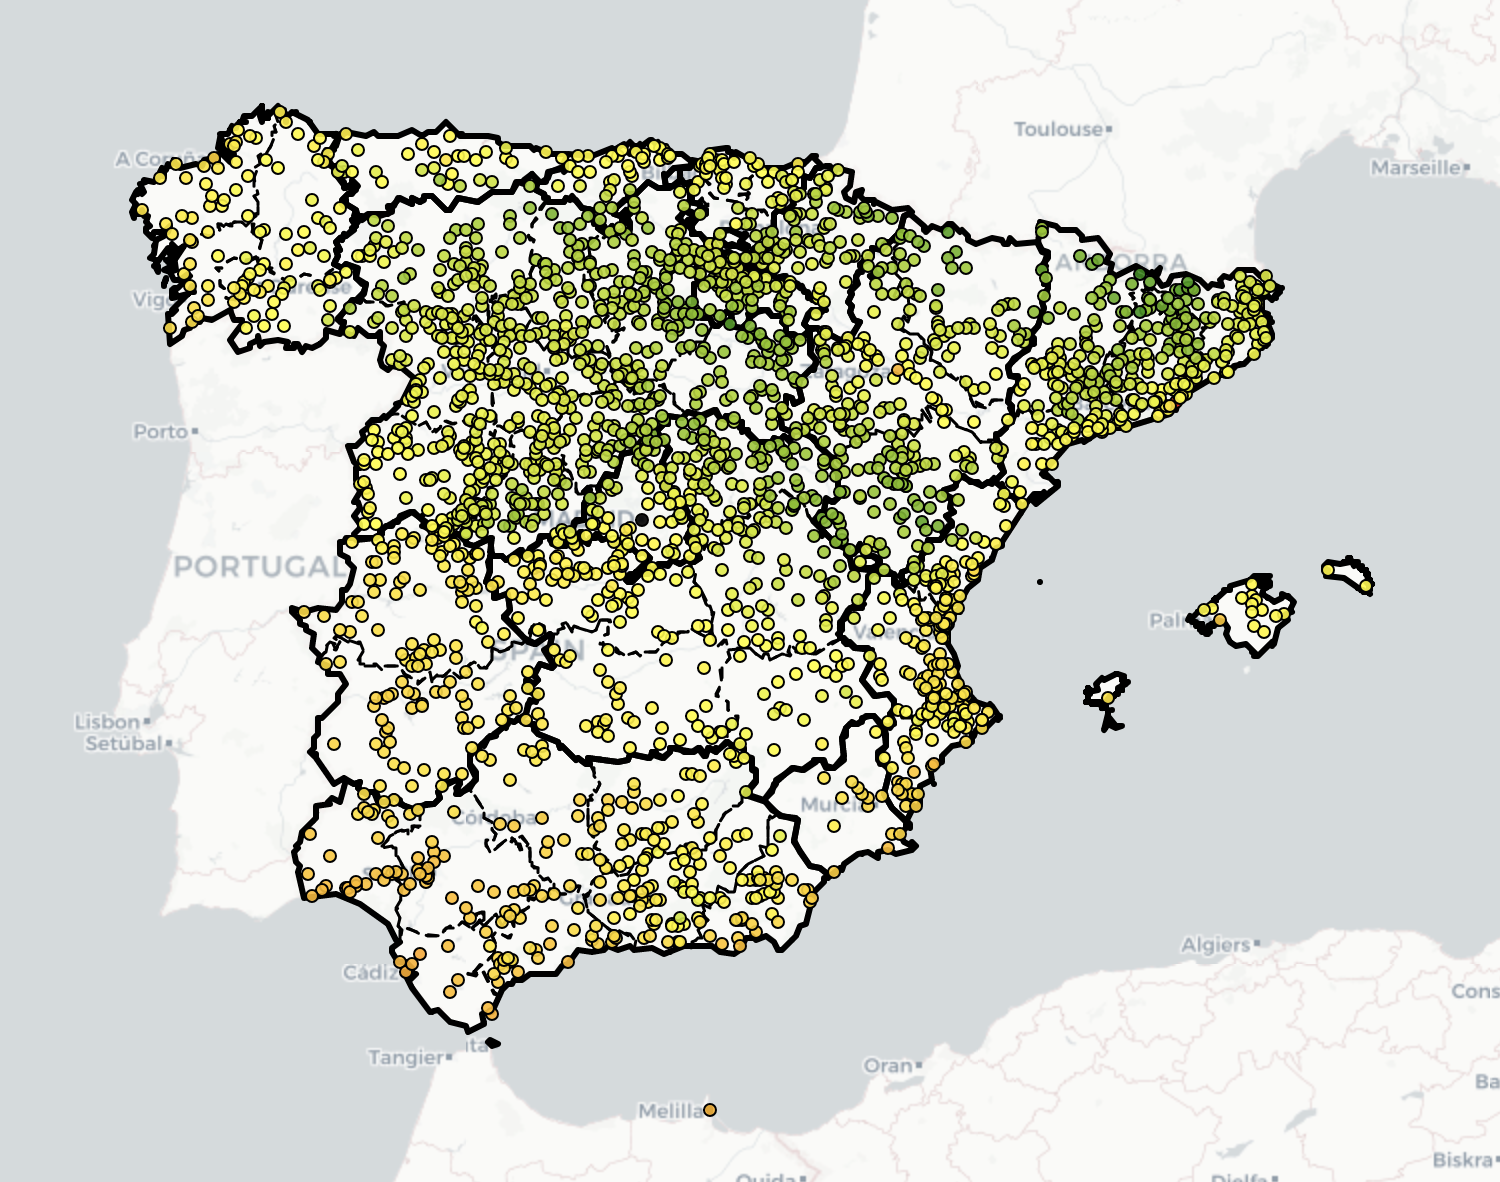

In [32]:
Image(filename='test_pred_lineal.png') 

Se ve que con el lineal, se hace una prediccion bastante uniforme y no nos detecta sitios donde hay mas paro, si que se observa mas tirando a rojo al sur, y mas tirando a verde en el norte. 

In [107]:
coef_dict = dict(zip(X.columns.values.tolist(),best_model1.named_steps["svr"].coef_.tolist()[0]))
print(coef_dict) #W: weights
print(best_model1.named_steps["svr"].intercept_) #b: intercept

{'lat': -0.010867644209691048, 'lon': -0.006759516725206116, 'alt': -0.01010179760041726, 'habitantes': 0.0016285886867394924}
[0.05212908]


La recta obtenida a partir del SVR es: 
${y}= w.X + b$

+ **y**: valores predichos

+ **X**: features empleadas para predecir

+ **w**: weight vector. Nos sirve para ver el peso que tiene cada una de las features sobre la variable objetivo(target). Cuanto mayor es su valor absoluto respecto al resto, mayor importancia tiene la variable.

    + Si el valor es **+** nos determina que un aumento de la feature supone un aumento del target. (Directamente Proporcional)
    
    + Si el valor es **-** nos determina que un aumento de la feature implica un decrecemiento de la variable objetivo (Inversamente proporcional). 
    

+ **b**: Intercept. Daria la referencia de paro por defecto (Promedio). 

Analizando los *Weight Vector*:
+ **Latitud**: presenta un valor negativo, lo que indica que a medida que te vas al sur mas paro hay, algo que tiene sentido. 
+ **Longitud**: tiene menos peso, lo que indica que la variable es poco relevante.
+ **Altitud**: Según el modelo, a mayor altitud menos paro... no era algo que de manera intuitiva se hubiera considerado.
+ **Habitantes**: Es el que aparenta tener menos peso, se refiere a los numeros de habitantes y es positivo. A mayor habitantes, mas paro. 


Let us **check if we can do better with a non-linear SVM**.

Empleamos **non-linear SVM** que acepta los hiperparámetros C, gamma y epsilon. Buscaremos los más optimo aplicando GridSearch CV. Para el Scoring utilizamos **neg_mean_squared_error**.:

In [108]:
Cs = [0.001,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5]
gammas= [1,1.5,2,3,4,5,6,7,8,9,10]
epsilons=  [0.006,0.01,0.02,0.03,0.04,0.05,0.1,0.5,1,2,4]

In [109]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

pl = Pipeline(steps=[("estandarizador", StandardScaler()),
                     ("svr", SVR(kernel='rbf'))])

hp= {"svr__C":Cs,
     "svr__epsilon":epsilons,
     "svr__gamma": gammas}

gs2 = GridSearchCV(estimator= pl,
                  param_grid=hp,
                  cv=5, #Numero de splits/iteraciones de cross validation
                  verbose=3, #Imprime el progreso
                  scoring='neg_mean_squared_error',
                  n_jobs=-1)

gs2.fit(X_train, Y_train)

Fitting 5 folds for each of 1815 candidates, totalling 9075 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 606 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 924 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 1423 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 1986 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2611 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3301 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 4108 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 5017 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 6096 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 7359 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 8492 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 9075 out of 9075 |

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('estandarizador', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'svr__C': [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5], 'svr__epsilon': [0.006, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 1, 2, 4], 'svr__gamma': [1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=3)

In [110]:
best_model2= gs2.best_estimator_
best_C2= gs2.best_params_["svr__C"]
best_epsilon2= gs2.best_params_["svr__epsilon"]
best_gamma2= gs2.best_params_["svr__gamma"]

In [111]:
gs2.best_params_

{'svr__C': 0.06, 'svr__epsilon': 0.01, 'svr__gamma': 3}

In [112]:
gs2.best_score_

-0.00039988618797358463

In [113]:
Y_pred2 = best_model2.predict(X_test)

/anaconda3/envs/svm_labs/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [114]:
#Lo transformo en un Pandas Series para poder hacer pd.concat y poder mostrarlo en el mapa. 
Y_pred2=pd.Series(Y_pred2, index=X_test.index)

In [115]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_test, Y_pred2)

0.00037258986129114983

Como se observa se ha conseguido reducir el mean squared error

In [116]:
_ = utils.generate_map(pd.concat([X_test, Y_pred2], axis=1),      # generate map, which needs X and Y together...
                       utils.LAT_FIELD, utils.LON_FIELD, Y_pred2.name if Y_pred2.name is not None else 0,   # columns with latitude, longitude and unemployment...
                       cmap, coms=coms, provs=provs, filename='./test_predicted2.html')    # colors, communities, provinces and where to store the map

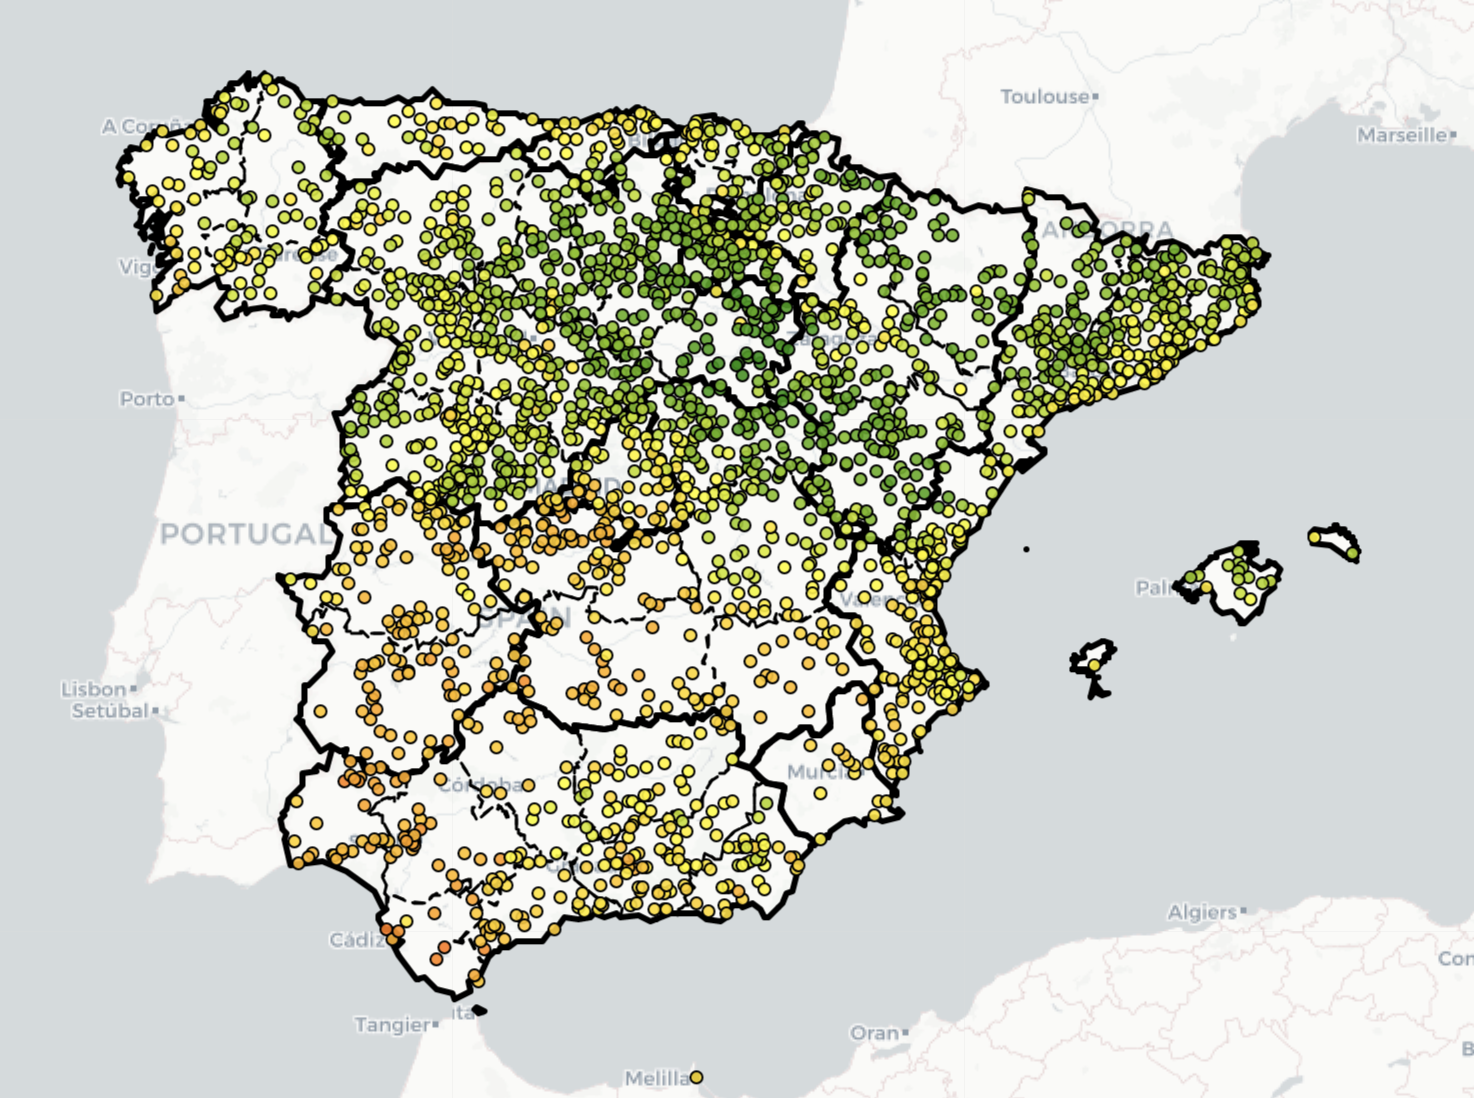

In [57]:
from IPython.display import Image
Image(filename='test_pred_rbf.png')

Como se puede observar se ha mejorado el modelo y por tanto se aproxima más al conjunto de test real.


## 3. Refined models

### 3.1. Previous years (2006-2015)

So far we have predicted unemployment rates for 2017 based solely on municipality fixed characteristics (namely coordinates, altitude and population). Fortunately, we also have the unemployment figures for years 2006-2016, so that **we can also use unemployment in previous years to try to predict what will happen next**, in a time series fashion. Omitting for the moment 2016 (we will use it later):

In [121]:
prev_years = range(2006, 2016)    # does not include 2016
prev_years

range(2006, 2016)

In [122]:
unempl_2006 = utils.read_unemployment('./data/Paro_por_municipios_2006.csv')
unempl_2007 = utils.read_unemployment('./data/Paro_por_municipios_2007.csv')
unempl_2008 = utils.read_unemployment('./data/Paro_por_municipios_2008.csv')
unempl_2009 = utils.read_unemployment('./data/Paro_por_municipios_2009.csv')
unempl_2010 = utils.read_unemployment('./data/Paro_por_municipios_2010.csv')
unempl_2011 = utils.read_unemployment('./data/Paro_por_municipios_2011.csv')
unempl_2012 = utils.read_unemployment('./data/Paro_por_municipios_2012.csv')
unempl_2013 = utils.read_unemployment('./data/Paro_por_municipios_2013.csv')
unempl_2014 = utils.read_unemployment('./data/Paro_por_municipios_2014.csv')
unempl_2015 = utils.read_unemployment('./data/Paro_por_municipios_2015.csv')

#Concat all files into one df
unempl_2006_2015= pd.concat([unempl_2006,unempl_2007,unempl_2008,unempl_2009,unempl_2010,unempl_2011,unempl_2012,unempl_2013,unempl_2014,unempl_2015])

In [123]:
unempl_2006_2015.head()

año  mes  parados
com_aut   prov    mun                          
Andalucía Almería Abla       2006    1       56
                  Abrucena   2006    1       50
                  Adra       2006    1      775
                  Albánchez  2006    1       14
                  Alboloduy  2006    1       24

**For each municipality, we expect to have 120 observations** (10 years, 12 months each). For example, again taking Abla in Almería the last 20 are:

In [124]:
unempl_2006_2015.xs(key='Abla', level=utils.MUN_FIELD, drop_level=False).tail(20)      # all records whose mun is Abla, keeping index intact

año  mes  parados
com_aut   prov    mun                     
Andalucía Almería Abla  2014    5      122
                  Abla  2014    6      132
                  Abla  2014    7      129
                  Abla  2014    8      134
                  Abla  2014    9      129
                  Abla  2014   10      120
                  Abla  2014   11      126
                  Abla  2014   12      124
                  Abla  2015    1      115
                  Abla  2015    2      109
                  Abla  2015    3      110
                  Abla  2015    4      113
                  Abla  2015    5      109
                  Abla  2015    6      108
                  Abla  2015    7      103
                  Abla  2015    8      106
                  Abla  2015    9       98
                  Abla  2015   10      104
                  Abla  2015   11      104
                  Abla  2015   12       97

**Again we can take yearly means** for each year:

In [125]:
unempl_2006_2015_means = unempl_2006_2015.groupby(unempl_2006_2015.index.names + ["año"])[[utils.UNEMPL_FIELD]].mean()   # group by all index levels, then take the mean
assert(len(unempl_2006_2015_means) == len(unempl_2006_2015) // 12)       # there should be just 1 row for each municipality
unempl_2006_2015_means['año'] = unempl_2006_2015_means.index.get_level_values('año')
unempl_2006_2015_means.head(12)

df_2006_2015=pd.merge(unempl_2006_2015_means, muns_population, on=['com_aut','prov','mun'], how="inner")
print(df_2006_2015.shape)
df_2006_2015.head()

(81110, 6)


parados   año       lat       lon       alt  \
com_aut   prov    mun                                                   
Andalucía Almería Abla  63.166667  2006  37.14114 -2.780104  871.1684   
                  Abla  48.583333  2007  37.14114 -2.780104  871.1684   
                  Abla  64.416667  2008  37.14114 -2.780104  871.1684   
                  Abla  73.000000  2009  37.14114 -2.780104  871.1684   
                  Abla  94.250000  2010  37.14114 -2.780104  871.1684   

                        habitantes  
com_aut   prov    mun               
Andalucía Almería Abla        1504  
                  Abla        1504  
                  Abla        1504  
                  Abla        1504  
                  Abla        1504

And **transform these raw means to rates**:

In [126]:
df_2006_2015["rate_parados"]=df_2006_2015["parados"]/df_2006_2015["habitantes"]

In [127]:
df_2006_2015_rate=df_2006_2015[["rate_parados","año"]]

In [128]:
df_2006_2015_rate.index.names

FrozenList(['com_aut', 'prov', 'mun'])

In [129]:
X2 = pd.pivot_table(df_2006_2015_rate, index=['com_aut','prov','mun'], columns='año')
X2.columns = X2.columns.droplevel()
X2.columns.name= None
X2.head()

2006      2007      2008      2009      2010  \
com_aut   prov    mun                                                           
Andalucía Almería Abla       0.041999  0.032303  0.042830  0.048537  0.062666   
                  Abrucena   0.033433  0.028710  0.039398  0.042195  0.058103   
                  Adra       0.044520  0.047532  0.070101  0.101591  0.121090   
                  Alboloduy  0.035361  0.038081  0.038081  0.046241  0.054649   
                  Albox      0.030417  0.032251  0.044723  0.068654  0.080545   

                                 2011      2012      2013      2014      2015  
com_aut   prov    mun                                                          
Andalucía Almería Abla       0.066268  0.075521  0.083167  0.084164  0.070700  
                  Abrucena   0.054561  0.063261  0.054375  0.057668  0.060776  
                  Adra       0.124588  0.128517  0.122834  0.124479  0.125792  
                  Alboloduy  0.060584  0.079624  0.079006  0.082221  0.070227  
                  Albox      0.083915  0.089685  0.094419  0.091467  0.090699

Verify that your matrix is correct:

In [130]:
assert(all(X2.index == X.index) and (len(X2.columns) == len(prev_years)))      # same exact municipalities than before, one column for each year

**Split these new patterns**:

In [131]:
X2_train=pd.merge(X_train, X2, on=['com_aut','prov','mun'], how="inner")[[2006,2007,2008,2009,2010,2011,2012,2013,2014,2015]]
X2_test=pd.merge(X_test, X2, on=['com_aut','prov','mun'], how="inner")[[2006,2007,2008,2009,2010,2011,2012,2013,2014,2015]]
print(X2_train.shape)
print(X_train.shape)
print(X2_test.shape)
print(X_test.shape)

(5677, 10)
(5677, 4)
(2434, 10)
(2434, 4)


Training and test municipalities should be the same as before:

In [132]:
assert(all(X2_train.index == X_train.index) and all(X2_train.columns == X2.columns) and     # same index, same columns for training
      all(X2_test.index == X_test.index) and all(X2_test.columns == X2_train.columns))     # and for testing

**Train and predict with a linear SVR with the new dataset**:

Empleamos **linear SVR** que acepta los hiperparámetros C y epsilon. Buscaremos el más optimo aplicando GridSearch CV. Para el Scoring utilizamos **neg_mean_squared_error**.:
+ **C**: Penalty parameter C of the error term.

+ **Epsilon**: Epsilon in the epsilon-SVR model. It specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value.

In [133]:
Cs = [0.00000001,0.000001,0.00001,0.0001,0.0005,0.001,0.01,0.1,1]

epsilons=  [0.000000000000001,0.0000000001,0.0000001,0.00001,0.0001,0.001,0.01,0.1]

In [134]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

pl = Pipeline(steps=[("estandarizador", StandardScaler()),
                     ("svr", SVR(kernel='linear'))])

hp= {"svr__C":Cs,
     "svr__epsilon":epsilons}

gs3 = GridSearchCV(estimator= pl,
                  param_grid=hp,
                  cv=10, #Numero de splits/iteraciones de cross validation
                  verbose=5, #Imprime el progreso
                  scoring='neg_mean_squared_error',
                  return_train_score=False,
                  n_jobs=-1)

gs3.fit(X2_train, Y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 13.4min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('estandarizador', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'svr__C': [1e-08, 1e-06, 1e-05, 0.0001, 0.0005, 0.001, 0.01, 0.1, 1], 'svr__epsilon': [1e-15, 1e-10, 1e-07, 1e-05, 0.0001, 0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='neg_mean_squared_error', verbose=5)

In [135]:
best_model3= gs3.best_estimator_
best_C3= gs3.best_params_["svr__C"]
best_epsilon3= gs3.best_params_["svr__epsilon"]
mses3= np.reshape(gs3.cv_results_['mean_test_score'], (len(Cs),len(epsilons)))

In [136]:
gs3.best_params_

{'svr__C': 0.1, 'svr__epsilon': 0.01}

In [137]:
gs3.best_score_

-0.00010563865675751683

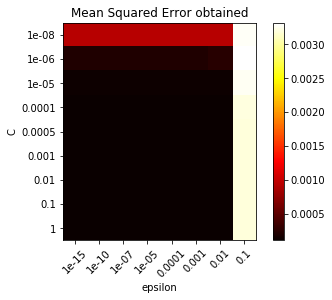

In [138]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(abs(mses3), interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('epsilon')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(epsilons)), epsilons, rotation=45)
plt.yticks(np.arange(len(Cs)), Cs)
plt.title('Mean Squared Error obtained')
plt.show()

#NOTA SI LOS MEJORES VALORES SALEN POR EL INTERIOR SE INDICA QUE LA BUSQUEDA HA SIDO BUENA, HEMOS PROBADO
#LOS PARAMETROS QUE QUERÍAMOS. 

In [139]:
Y_pred3 = best_model3.predict(X2_test)

In [140]:
#Lo transformo en un Pandas Series para poder hacer pd.concat y poder mostrarlo en el mapa. 
Y_pred3=pd.Series(Y_pred3, index=X2_test.index)

In [141]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_test, Y_pred3)

0.00010011417874804276

In [93]:
coef_dict = dict(zip(X2_test.columns.values.tolist(),best_model3.named_steps["svr"].coef_.tolist()[0]))
print(coef_dict) #W: weights
print(best_model3.named_steps["svr"].intercept_) #b: intercept


{2006: 0.0012489448376564738, 2007: -2.4646226807867322e-05, 2008: 0.0006787648800035129, 2009: 0.0015343187290292049, 2010: -0.0011757558795060241, 2011: 0.0021666411283588483, 2012: 0.0008713863045406445, 2013: 0.002421278310386521, 2014: 0.0003514869327649883, 2015: 0.021527591432132676}
[0.05169336]


Como era de esperar el valor que es mas alto es el 2015. Esto indica que tiene mayor impacto en la predicción. Tiene sentido porque el 2015 es el año mas proximo al año que buscamos predecir.

**See if a non-linear SVR can improve further**:

In [33]:
Cs = [0.001,0.01,0.1,1,10]
gammas= [0.0001,0.001,0.1,1,5,10]
epsilons=  [0.00001,0.0001,0.001,0.01,0.1,1,5,10]

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

pl = Pipeline(steps=[("estandarizador", StandardScaler()),
                     ("svr", SVR(kernel='rbf'))])

hp= {"svr__C":Cs,
     "svr__epsilon":epsilons,
     "svr__gamma": gammas}

gs4 = GridSearchCV(estimator= pl,
                  param_grid=hp,
                  cv=10, #Numero de splits/iteraciones de cross validation
                  verbose=5, #Imprime el progreso
                  scoring='neg_mean_squared_error',
                  return_train_score=False,
                  n_jobs=-1)

gs4.fit(X2_train, Y_train)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 477 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1074 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1385 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1745 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 2309 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 10.3min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('estandarizador', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'svr__C': [0.001, 0.01, 0.1, 1, 10], 'svr__epsilon': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10], 'svr__gamma': [0.0001, 0.001, 0.1, 1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='neg_mean_squared_error', verbose=5)

In [35]:
best_model4= gs4.best_estimator_
best_C4= gs4.best_params_["svr__C"]
best_epsilon4= gs4.best_params_["svr__epsilon"]
best_gamma4= gs4.best_params_["svr__gamma"]

In [36]:
gs4.best_params_

{'svr__C': 1, 'svr__epsilon': 0.01, 'svr__gamma': 0.001}

In [38]:
gs4.best_score_

-0.0001042527113626094

In [39]:
Y_pred4 = best_model4.predict(X2_test)

In [40]:
#Lo transformo en un Pandas Series para poder hacer pd.concat y poder mostrarlo en el mapa. 
Y_pred4=pd.Series(Y_pred4, index=X2_test.index)

In [41]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_test, Y_pred4)

9.844362940880262e-05

In [42]:
_ = utils.generate_map(pd.concat([X_test, Y_pred4], axis=1),      # generate map, which needs X and Y together...
                       utils.LAT_FIELD, utils.LON_FIELD, Y_pred4.name if Y_pred4.name is not None else 0,   # columns with latitude, longitude and unemployment...
                       cmap, coms=coms, provs=provs, filename='./test_predicted4.html')    # colors, communities, provinces and where to store the map

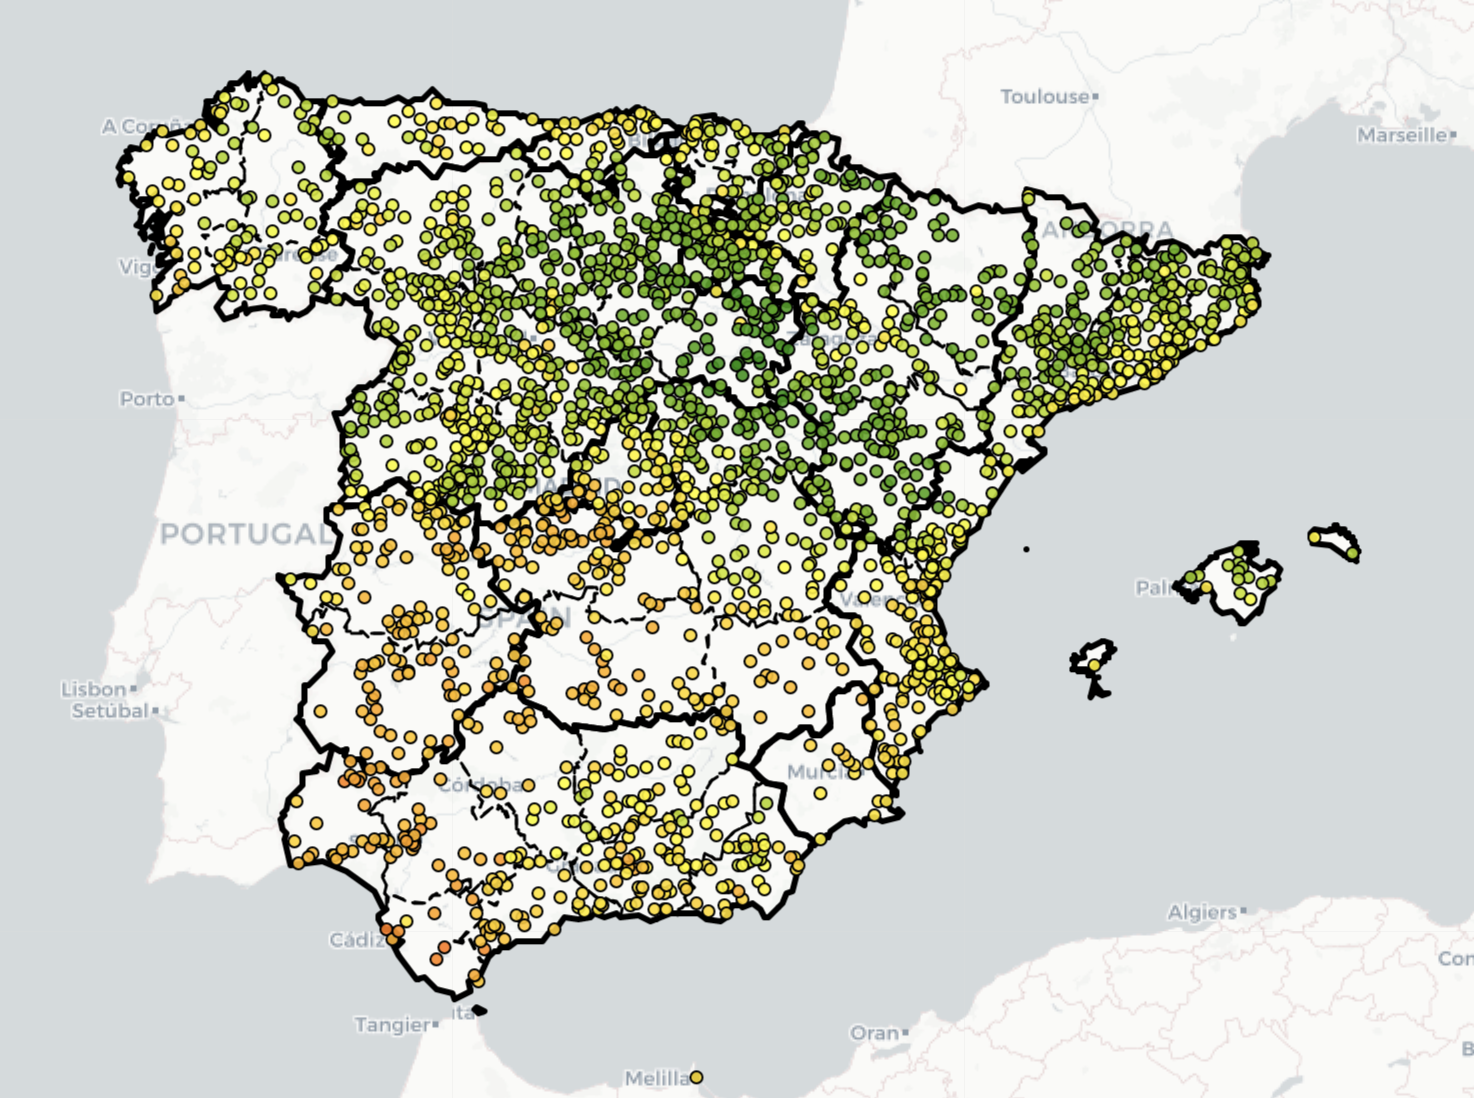

In [256]:
Image(filename='test_pred_rbf2.png')

### 3.2 Previous years 2006-2015 + 2016

Time to **check whether introducing year 2016 helps or not**:

In [147]:
unempl_2016 = utils.read_unemployment('./data/Paro_por_municipios_2016.csv')

In [148]:
unempl_2016.xs(key='Abla', level=utils.MUN_FIELD, drop_level=False)      # all records whose mun is Abla, keeping index intact

año  mes  parados
com_aut   prov    mun                     
Andalucía Almería Abla  2016    1       94
                  Abla  2016    2      102
                  Abla  2016    3      102
                  Abla  2016    4       93
                  Abla  2016    5       98
                  Abla  2016    6      101
                  Abla  2016    7       91
                  Abla  2016    8       87
                  Abla  2016    9       97
                  Abla  2016   10       95
                  Abla  2016   11      102
                  Abla  2016   12       83

In [149]:
unempl_2016_means = unempl_2016.groupby(unempl_2016.index.names + ["año"])[[utils.UNEMPL_FIELD]].mean()   # group by all index levels, then take the mean
unempl_2016_means['año'] = unempl_2016_means.index.get_level_values('año')
unempl_2016_means.head(12)

df_2016=pd.merge(unempl_2016_means, muns_population, on=['com_aut','prov','mun'], how="inner")
print(df_2016.shape)
df_2016.head()

(8111, 6)


parados   año       lat       lon        alt  \
com_aut   prov    mun                                                           
Andalucía Almería Abla         95.416667  2016  37.14114 -2.780104  871.16840   
                  Abrucena     79.500000  2016  37.13305 -2.797098  976.93870   
                  Adra       2703.000000  2016  36.74807 -3.022522   10.97898   
                  Alboloduy    46.166667  2016  37.03319 -2.621750  388.43460   
                  Albox       902.250000  2016  37.38979 -2.147483  426.42680   

                             habitantes  
com_aut   prov    mun                    
Andalucía Almería Abla             1504  
                  Abrucena         1341  
                  Adra            24373  
                  Alboloduy         674  
                  Albox           11178

In [150]:
df_2016["rate_parados"]=df_2016["parados"]/df_2016["habitantes"]

In [151]:
df_2016_rate=df_2016[["rate_parados","año"]]

In [152]:
df_2016_rate.index.names

FrozenList(['com_aut', 'prov', 'mun'])

In [153]:
X3 = pd.pivot_table(df_2016_rate, index=['com_aut','prov','mun'], columns='año')
X3.columns = X3.columns.droplevel()
X3.columns.name= None
X3.head()

2016
com_aut   prov    mun                
Andalucía Almería Abla       0.063442
                  Abrucena   0.059284
                  Adra       0.110901
                  Alboloduy  0.068497
                  Albox      0.080717

In [154]:
X3_train=pd.merge(X2_train, X3, on=['com_aut','prov','mun'], how="inner")
X3_test=pd.merge(X2_test, X3, on=['com_aut','prov','mun'], how="inner")
print(X3_train.shape)
print(X2_train.shape)
print(X3_test.shape)
print(X2_test.shape)

(5677, 11)
(5677, 10)
(2434, 11)
(2434, 10)


**Train the new linear model**:

In [155]:
Cs = [0.001,0.01,0.1]
epsilons=  [0.000000000000001,0.0000000001,0.00000001,0.0000001, 0.000001,0.00001]

In [156]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

pl = Pipeline(steps=[("estandarizador", StandardScaler()),
                     ("svr", SVR(kernel='linear'))])

hp= {"svr__C":Cs,
     "svr__epsilon":epsilons}

gs5 = GridSearchCV(estimator= pl,
                  param_grid=hp,
                  cv=10, #Numero de splits/iteraciones de cross validation
                  verbose=5, #Imprime el progreso
                  scoring='neg_mean_squared_error',
                  return_train_score=False,
                  n_jobs=-1)

gs5.fit(X3_train, Y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.1min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('estandarizador', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'svr__C': [0.001, 0.01, 0.1], 'svr__epsilon': [1e-15, 1e-10, 1e-08, 1e-07, 1e-06, 1e-05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='neg_mean_squared_error', verbose=5)

In [157]:
best_model5= gs5.best_estimator_
best_C5= gs5.best_params_["svr__C"]
best_epsilon5= gs5.best_params_["svr__epsilon"]
mses5= np.reshape(gs5.cv_results_['mean_test_score'], (len(Cs),len(epsilons)))

In [158]:
gs5.best_params_

{'svr__C': 0.01, 'svr__epsilon': 1e-08}

In [159]:
gs5.best_score_

-5.772441119960443e-05

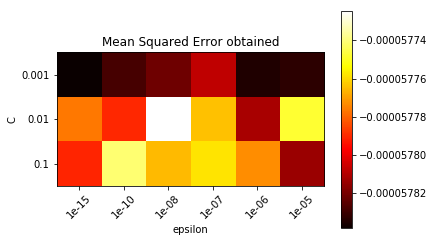

In [294]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(mses5, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('epsilon')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(epsilons)), epsilons, rotation=45)
plt.yticks(np.arange(len(Cs)), Cs)
plt.title('Mean Squared Error obtained')
plt.show()

#NOTA SI LOS MEJORES VALORES SALEN POR EL INTERIOR SE INDICA QUE LA BUSQUEDA HA SIDO BUENA, HEMOS PROBADO
#LOS PARAMETROS QUE QUERÍAMOS. 

In [160]:
Y_pred5 = best_model5.predict(X3_test)
Y_pred5=pd.Series(Y_pred5, index=X3_test.index)
mean_squared_error(Y_test, Y_pred5)

5.742079839844658e-05

In [161]:
_ = utils.generate_map(pd.concat([X_test, Y_pred5], axis=1),      # generate map, which needs X and Y together...
                       utils.LAT_FIELD, utils.LON_FIELD, Y_pred5.name if Y_pred5.name is not None else 0,   # columns with latitude, longitude and unemployment...
                       cmap, coms=coms, provs=provs, filename='./test_predicted5.html')    # colors, communities, provinces and where to store the map

In [162]:
coef_dict = dict(zip(X3_test.columns.values.tolist(),best_model5.named_steps["svr"].coef_.tolist()[0]))
print(coef_dict) #W: weights
print(best_model5.named_steps["svr"].intercept_) #b: intercept


{2006: -0.0001063284106606055, 2007: 0.0007968741362816278, 2008: 0.0005769718903211873, 2009: -0.0006075918449482964, 2010: -1.0776013640578785e-05, 2011: 0.0011112333638657323, 2012: -0.0013679857353137703, 2013: 0.0017875420638067407, 2014: 0.0015812740732097652, 2015: -0.0019202712557813834, 2016: 0.02841233170398036}
[0.05150233]


El peso que tiene el 2016 es muy fuerte. Logicamente cuanto más proximo al año de predicción, mas poder predictivo. Por lo que mejora considerablemente el modelo.

And **finally a non-linear model**:

In [52]:
Cs = [0.001,0.01,0.1,1,5,7,10]
gammas= [0.00001,0.0001,0.001,0.1,1,1.5]
epsilons=  [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10]

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

pl = Pipeline(steps=[("estandarizador", StandardScaler()),
                     ("svr", SVR(kernel='rbf'))])

hp= {"svr__C":Cs,
     "svr__epsilon":epsilons,
     "svr__gamma": gammas}

gs6 = GridSearchCV(estimator= pl,
                  param_grid=hp,
                  cv=10, #Numero de splits/iteraciones de cross validation
                  verbose=5, #Imprime el progreso
                  scoring='neg_mean_squared_error',
                  return_train_score=False,
                  n_jobs=-1)

gs6.fit(X3_train, Y_train)

Fitting 10 folds for each of 336 candidates, totalling 3360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 470 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 700 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1098 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1424 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1874 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 3064 tasks      | elapsed: 29.1min
[Parallel(n_jobs=-1)]: Done 3337 out of 3360 | elapsed: 33.0min remaining:   13.7s
[Parallel(n_jobs=-1)]: Done 3360 out of 3360 | elapsed: 33.1min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('estandarizador', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'svr__C': [0.001, 0.01, 0.1, 1, 5, 7, 10], 'svr__epsilon': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10], 'svr__gamma': [1e-05, 0.0001, 0.001, 0.1, 1, 1.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='neg_mean_squared_error', verbose=5)

In [54]:
best_model6= gs6.best_estimator_
best_C6= gs6.best_params_["svr__C"]
best_epsilon6= gs6.best_params_["svr__epsilon"]
best_gamma6= gs6.best_params_["svr__gamma"]

In [55]:
gs6.best_params_

{'svr__C': 10, 'svr__epsilon': 0.001, 'svr__gamma': 0.0001}

NOTA: No pongo un C mas alto porque a veces me daba 5 y otras 10, seguramente esté entre medias, pero he visto que varia poco el *mean squared error*.

In [56]:
gs6.best_score_

-5.7460948756482817e-05

In [59]:
Y_pred6 = best_model6.predict(X3_test)
Y_pred6=pd.Series(Y_pred6, index=X3_test.index)
mse6=mean_squared_error(Y_test, Y_pred6)

## 4. Summary

In [174]:
print('Modelo 1: mse (Test):{0} | C:{1} | Epsilon:{2}'.format(mean_squared_error(Y_test, Y_pred1), best_C1,best_epsilon1))
print('Modelo 2: mse (Test):{0} | C:{1} | Epsilon:{2} | Gamma:{3}'.format(mean_squared_error(Y_test, Y_pred2), best_C2, best_epsilon2, best_gamma2))
print('Modelo 3: mse (Test):{0} | C:{1} | Epsilon:{2}'.format(mean_squared_error(Y_test, Y_pred3), best_C3,best_epsilon3))
print('Modelo 4: mse (Test):{0} | C:{1} | Epsilon:{2} | Gamma:{3}'.format(mean_squared_error(Y_test, Y_pred4), best_C4, best_epsilon4, best_gamma4))
print('Modelo 5: mse (Test):{0} | C:{1} | Epsilon:{2}'.format(mean_squared_error(Y_test, Y_pred5), best_C5,best_epsilon5))
print('Modelo 6: mse (Test):{0} | C:{1} | Epsilon:{2} | Gamma:{3}'.format(mean_squared_error(Y_test, Y_pred6), best_C6, best_epsilon6, best_gamma6))

Modelo 1: mse (Test):0.0006101162735897806 | C:0.00025 | Epsilon:0.025
Modelo 2: mse (Test):0.00037258986129114983 | C:0.06 | Epsilon:0.01 | Gamma:3
Modelo 3: mse (Test):0.00010011417874804276 | C:0.1 | Epsilon:0.01
Modelo 4: mse (Test):9.844362940880262e-05 | C:1 | Epsilon:0.01 | Gamma:0.001
Modelo 5: mse (Test):5.742079839844658e-05 | C:0.01 | Epsilon:1e-08
Modelo 6: mse (Test):5.6808058415938504e-05 | C:10 | Epsilon:0.001 | Gamma:0.0001


### ANOTACIONES RESULTADOS

Logicamente para obtener mejores resultados cuanto mas información mejor. El rbf se nota más cuando **no** incluiamos los años anteriores cercanos a la fecha a predecir el paro, si no que nos basamos unicamente en altitud, latitud, etc. (Atributos no temporales). 

El mejor resultado en test ha sido con el modelo 6, sin embargo puedo decir que el modelo 5 es más simple y tiene un comportamiento próximo. Para el primer estudio sin duda merece la pena utilizar el kernel rbf.